In [1]:
import pandas as pd
import numpy as np
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from lightkurve import search_targetpixelfile
import os
import lightkurve as lk
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

/Users/sabina/miniconda3/envs/starry-env/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


In [2]:
%matplotlib inline

In [3]:
kic_ids = [5111207, 5023899, 5024227, 5023760, 5024122, 5113601, 5112499, 5026583, 4938993, 5111834,
            5111908, 5024856, 5112507, 5024280, 5023796, 5024008, 5023724, 5023875, 5112268, 5111939,
            5025271, 4937169, 5112871, 5023666, 5024182, 5023926, 4937149, 4936891, 4937119, 4937356]

def get_coords(kic_id):
    search_result = lk.search_lightcurve(f'KIC {kic_id}', mission='Kepler')
    if len(search_result) > 0:
        ra = search_result[0].ra[0]
        dec = search_result[0].dec[0]
        coords = SkyCoord(ra, dec, unit='deg')
        return {
            'RA_decimal': ra,
            'Dec_decimal': dec,
            'RA_sexagesimal': coords.ra.to_string(unit='hourangle', sep=':'),
            'Dec_sexagesimal': coords.dec.to_string(unit='deg', sep=':')
        }
    return None

star_dict = {}

for kic_id in kic_ids:
    coords = get_coords(kic_id)
    if coords:
        star_dict[kic_id] = coords
    else:
        print(f"Could not find coordinates for KIC {kic_id}")

for kic, data in star_dict.items():
    print(f"KIC {kic}:")
    print(f"  RA (sexagesimal): {data['RA_sexagesimal']}")
    print(f"  Dec (sexagesimal): {data['Dec_sexagesimal']}")
    print(f"  RA (decimal degrees): {data['RA_decimal']}")
    print(f"  Dec (decimal degrees): {data['Dec_decimal']}")
    print()

KIC 5111207:
  RA (sexagesimal): 19:40:09.0192
  Dec (sexagesimal): 40:12:16.74
  RA (decimal degrees): 295.03757999999993
  Dec (decimal degrees): 40.20465

KIC 5023899:
  RA (sexagesimal): 19:40:55.9056
  Dec (sexagesimal): 40:10:04.728
  RA (decimal degrees): 295.23294
  Dec (decimal degrees): 40.16798

KIC 5024227:
  RA (sexagesimal): 19:41:09.49464
  Dec (sexagesimal): 40:11:41.64
  RA (decimal degrees): 295.28956100000005
  Dec (decimal degrees): 40.1949

KIC 5023760:
  RA (sexagesimal): 19:40:49.3392
  Dec (sexagesimal): 40:09:07.056
  RA (decimal degrees): 295.20558000000005
  Dec (decimal degrees): 40.15196

KIC 5024122:
  RA (sexagesimal): 19:41:05.5104
  Dec (sexagesimal): 40:08:28.356
  RA (decimal degrees): 295.27296
  Dec (decimal degrees): 40.14121

KIC 5113601:
  RA (sexagesimal): 19:42:00.1872
  Dec (sexagesimal): 40:12:19.116
  RA (decimal degrees): 295.5007800000001
  Dec (decimal degrees): 40.20531

KIC 5112499:
  RA (sexagesimal): 19:41:13.90824
  Dec (sexagesimal)

In [6]:
from astroquery.simbad import Simbad
import numpy as np
from astropy.table import Table
import time

def kic_to_tic(kic_ids):
    """
    Convert KIC IDs to TIC IDs using SIMBAD database
    
    Parameters:
    -----------
    kic_ids : list
        List of KIC IDs to query
        
    Returns:
    --------
    dict
        Dictionary with KIC IDs as keys and TIC IDs as values.
        If TIC ID is not found, value will be None
    """
    
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ids')
    
    
    results = {}
    
    for kic_id in kic_ids:
        try:
            
            query_result = customSimbad.query_object(f"KIC {kic_id}")
            
            if query_result is not None:
                
                all_ids = query_result['IDS'][0].split('|')
                
                
                tic_id = None
                for id_string in all_ids:
                    if 'TIC' in id_string:
                        tic_id = id_string.strip().replace('TIC ', '')
                        break
                
                results[kic_id] = tic_id
            else:
                print(f"No SIMBAD entry found for KIC {kic_id}")
                results[kic_id] = None
                
        except Exception as e:
            print(f"Error processing KIC {kic_id}: {str(e)}")
            results[kic_id] = None
            
        
        time.sleep(1)
    
    return results


kic_ids = [5111207, 5023899, 5024227, 5023760, 5024122, 5113601, 5112499, 
           5026583, 4938993, 5111834, 5111908, 5024856, 5112507, 5024280, 
           5023796, 5024008, 5023724, 5023875, 5112268, 5111939, 5025271, 
           4937169, 5112871, 5023666, 5024182, 5023926, 4937149, 4936891, 
           4937119, 4937356]


tic_results = kic_to_tic(kic_ids)


for kic_id, tic_id in tic_results.items():
    print(f"KIC {kic_id}: TIC {tic_id if tic_id else 'Not found'}")


output_table = Table([list(tic_results.keys()), list(tic_results.values())],
                    names=('KIC_ID', 'TIC_ID'))
output_table.write('kic_to_tic_results.csv', format='csv', overwrite=True)

KIC 5111207: TIC 138960309
KIC 5023899: TIC 139109608
KIC 5024227: TIC 139153918
KIC 5023760: TIC 138970733
KIC 5024122: TIC 139109420
KIC 5113601: TIC 184010775
KIC 5112499: TIC 139154440
KIC 5026583: TIC 184163632
KIC 4938993: TIC 184164110
KIC 5111834: TIC 138970327
KIC 5111908: TIC 138970485
KIC 5024856: TIC 184011049
KIC 5112507: TIC 139154609
KIC 5024280: TIC 139109431
KIC 5023796: TIC 139109561
KIC 5024008: TIC 139153727
KIC 5023724: TIC 138970830
KIC 5023875: TIC 139109511
KIC 5112268: TIC 139154323
KIC 5111939: TIC 138970548
KIC 5025271: TIC 184010986
KIC 4937169: TIC 139109179
KIC 5112871: TIC 139154491
KIC 5023666: TIC 138970667
KIC 5024182: TIC 139109464
KIC 5023926: TIC 139109212
KIC 4937149: TIC 139109145
KIC 4936891: TIC 139109190
KIC 4937119: TIC 139109171
KIC 4937356: TIC 184011293


In [20]:
search_result = lk.search_targetpixelfile('TIC 184011293')

In [21]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 02,2009,Kepler,1800,kplr004937356,0.0
1,Kepler Quarter 03,2009,Kepler,1800,kplr004937356,0.0
2,Kepler Quarter 07,2010,Kepler,1800,kplr004937356,0.0
3,Kepler Quarter 08,2011,Kepler,1800,kplr004937356,0.0
4,Kepler Quarter 09,2011,Kepler,1800,kplr004937356,0.0
5,Kepler Quarter 15,2013,Kepler,1800,kplr004937356,0.0
6,Kepler Quarter 16,2013,Kepler,1800,kplr004937356,0.0
7,Kepler Quarter 17,2013,Kepler,1800,kplr004937356,0.0


In [22]:
def while_loop(command,message,wait_time):
    """
    Executes a command in a while loop until it successfully completes, handling 
    potential exceptions and retrying after a specified wait time.
    Parameters:
    -----------
    command : callable
        The command or function to be executed. It must be callable without parentheses 
        (i.e., not executed immediately) and passed as an argument.
        
    message : str
        A message to be printed each time an exception is caught, indicating that
        the loop is retrying the command.
        
    wait_time : float
        The number of seconds to wait between retry attempts after an exception occurs.
    Returns:
    --------
    result : any
        The result of the successfully executed command, returned after the loop exits.    
    """
    import time as clock
    import astroquery
    import requests
    import urllib
    from lightkurve.search import SearchError
    from astroquery.exceptions import RemoteServiceError
    from requests.exceptions import HTTPError
    try_again=True
    while try_again:
        try:
            result = command
            try_again=False
        except (TimeoutError,HTTPError,RemoteServiceError,SearchError,astroquery.exceptions.TimeoutError, requests.exception.HTTPError,requests.exceptions.ReadTimeout,requests.exceptions.ConnectionError,urllib.error.URLError,TypeError,KeyError) as E:
            print(E)
            print(message)
            clock.sleep(wait_time)
            print('')
    return result

def collect_nearby_TIC_params(ID,N_TESS_pixels,verbose=False,downloadpath=None):
    """
    Queries the TESS Input Catalog (TIC) for stellar parameters of the
    target star and nearby stars within a given radius.  The radius is 
    defined by the number of TESS pixels.

    Parameters:
    -----------
    ID : int or str
        The TIC ID of the target star.
    N_TESS_pixels : float
        The number of TESS pixels to define the radius for nearby star search.
    verbose : bool, optional
        If `True`, additional details will be printed during execution 
        (default is `False`).
    downloadpath : str, optional
        Path to a custom download location for caching the TIC query. 
        If not provided, default cache settings will be used.
    Returns:
    --------
    star : pandas.DataFrame
        DataFrame containing the queried stellar parameters for the target star.
    nearby_star_catalog : pandas.DataFrame
        DataFrame containing stellar parameters for nearby stars within
        the specified radius.
    """
    from astroquery.mast import Catalogs
    if type(downloadpath)!=type(None):        
        Catalogs.cache_location=downloadpath
    import astropy.units as u
    radial_cone = (N_TESS_pixels*21.0 * (u.arcsec/u.pixel)* (1 * u.pixel)).to(u.degree).value    
#     result = while_loop(command = Catalogs.query_object(starName, catalog = "TIC", radius=Angle(cone, "arcsec"))[0] ,\
#                     message = 'Trying TIC query from MAST again in 2 seconds',\
#                     wait_time = 1)
    starName='TIC '+str(ID)
    result = while_loop(command = Catalogs.query_object(starName, radius = radial_cone, catalog = "TIC").to_pandas() ,\
                    message = 'Trying TIC query from MAST again in 2 seconds',\
                    wait_time = 1)
    
    result_filtered = result#.loc[result['disposition']!='DUPLICATE'].reset_index(drop=True)
#     result_filtered = result[~result['disposition'].isin(['ARTIFACT', 'DUPLICATE', 'SPLIT'])].reset_index(drop=True)
    star = result_filtered.loc[result_filtered['ID']==str(ID)].reset_index(drop=True)
    if len(star)<1:        
        print('TIC ',ID,'star length:',len(star),'result length:',len(result))
        star = result.loc[result['ID']==str(ID)].reset_index(drop=True)
#         if type(star['disposition'].item())==str:
        print('TIC '+str(ID)+' has TIC Disposition '+str(star['disposition'].item()))
        star=result.loc[ (result['GAIA']==star['GAIA'].item()) &
                         (result['duplicate_id']==str(ID)) ].reset_index(drop=True)
        print('TIC ',ID,'new star length:',len(star),'new result length:',len(result))
    # star = get_qld(star, verbose)    
    nearby_star_catalog = result    
    return star,nearby_star_catalog

In [23]:
data = pd.read_csv('kic_to_tic_results.csv')
tic_ids = data['TIC_ID'].to_list()

In [25]:
tic_ids

[138960309,
 139109608,
 139153918,
 138970733,
 139109420,
 184010775,
 139154440,
 184163632,
 184164110,
 138970327,
 138970485,
 184011049,
 139154609,
 139109431,
 139109561,
 139153727,
 138970830,
 139109511,
 139154323,
 138970548,
 184010986,
 139109179,
 139154491,
 138970667,
 139109464,
 139109212,
 139109145,
 139109190,
 139109171,
 184011293]

In [30]:
stars_info = []
for tic_id in tic_ids:
    stars_info.append(collect_nearby_TIC_params(tic_id, 3)[0])

In [31]:
stars_info = pd.concat(stars_info)

In [33]:
np.sum(stars_info['Tmag']<16)

9

In [34]:
stars_info

,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
0,138960309,295.037561,40.204642,-2.96576,-3.78846,14.7003,STAR,tmgaia2,20190415,NaN,...,NaN,0.784541,0.770908,295.037545,40.204625,0.021069,0.026827,1,0,0.0
0,139109608,295.232936,40.167977,-2.97812,-3.72422,14.6556,STAR,tmgaia2,20190415,NaN,...,NaN,0.650078,0.610346,295.232920,40.167961,0.018018,0.020465,1,0,0.0
0,139153918,295.289545,40.194888,-2.84296,-3.84888,14.7291,STAR,tmgaia2,20190415,NaN,...,NaN,0.774986,0.999808,295.289529,40.194872,0.020185,0.027702,1,0,0.0
0,138970733,295.205591,40.151946,-2.98724,-3.92036,14.7150,STAR,tmgaia2,20190415,NaN,...,NaN,0.670163,0.639387,295.205574,40.151929,0.018043,0.021105,1,0,0.0
0,139109420,295.272916,40.141228,-2.94030,-3.82496,15.2763,STAR,tmgaia2,20190415,NaN,...,NaN,0.880929,0.823846,295.272900,40.141212,0.023759,0.027610,1,0,0.0
0,184010775,295.500784,40.205318,-2.97412,-3.62039,15.1958,STAR,tmgaia2,20190415,NaN,...,NaN,0.979866,0.936989,295.500767,40.205303,0.026423,0.032697,1,0,0.0
0,139154440,295.307951,40.258406,-2.79002,-3.99497,15.0257,STAR,tmgaia2,20190415,NaN,...,NaN,0.796163,0.909822,295.307935,40.258389,0.024536,0.030280,1,0,0.0
0,184163632,295.730216,40.163321,-3.11673,-3.91233,15.2248,STAR,tmgaia2,20190415,NaN,...,NaN,0.927038,0.916982,295.730199,40.163304,0.025043,0.033438,1,0,0.0
0,184164110,295.732751,40.005511,-2.76180,-4.08050,15.1921,STAR,tmgaia2,20190415,NaN,...,NaN,0.858764,0.799032,295.732735,40.005493,0.023601,0.028115,1,0,0.0
0,138970327,295.182796,40.255109,-2.81115,-3.85143,16.1776,STAR,tmgaia2,20190415,NaN,...,NaN,1.863468,1.655550,295.182780,40.255092,0.046104,0.053448,1,0,0.0


In [86]:
search_result = lk.search_tesscut('TIC 139109171').download_all(cutout_size=11)

<Axes: title={'center': 'Target ID: TIC 139109171, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

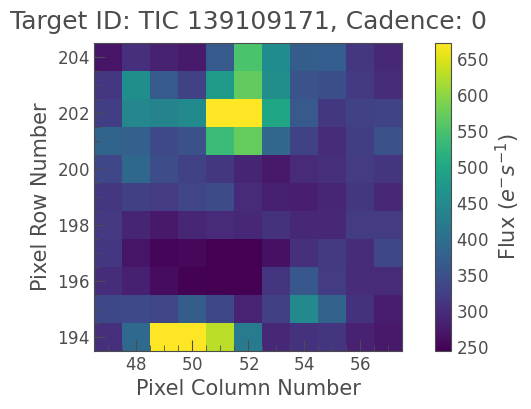

In [87]:
search_result[0].plot()

In [49]:
search_result[0].column

52

In [88]:
def plot_traget(tpf):
    x = tpf.hdu[1].header['1CRPX4']+tpf.column
    y = tpf.hdu[1].header['2CRPX4']+tpf.row

    ax = tpf.plot()
    ax.plot(x,y,marker='*', color='white')
    plt.show()

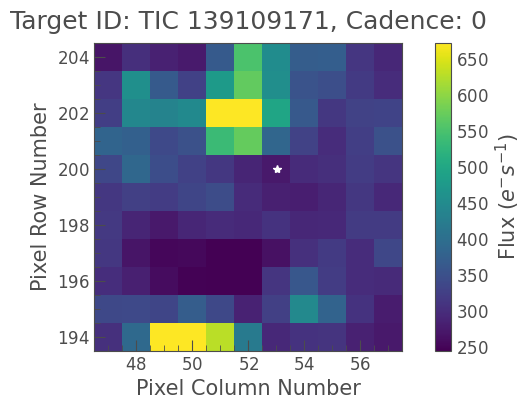

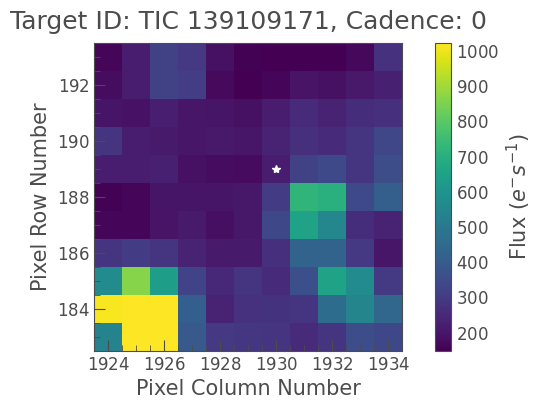

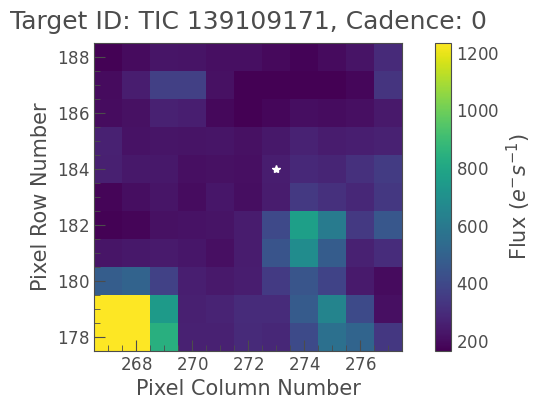

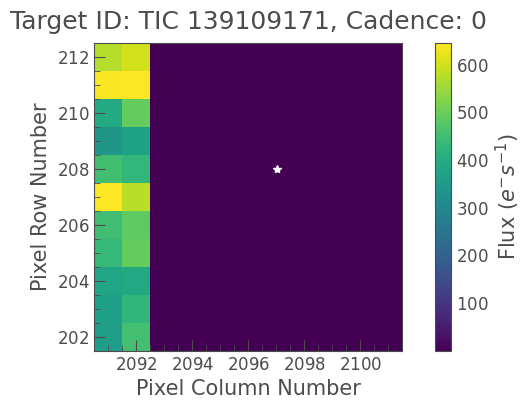

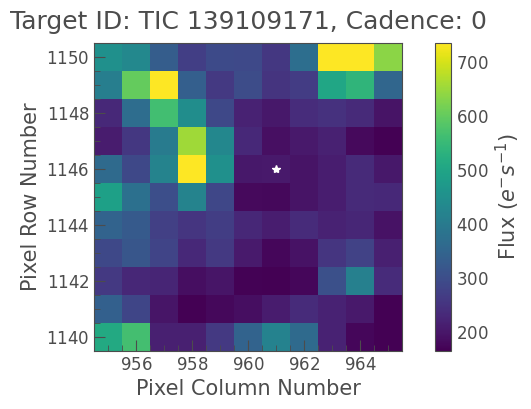

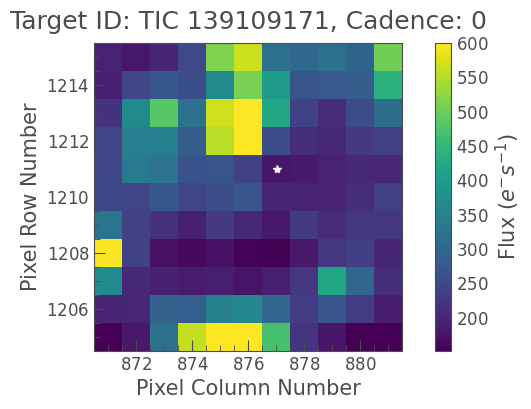

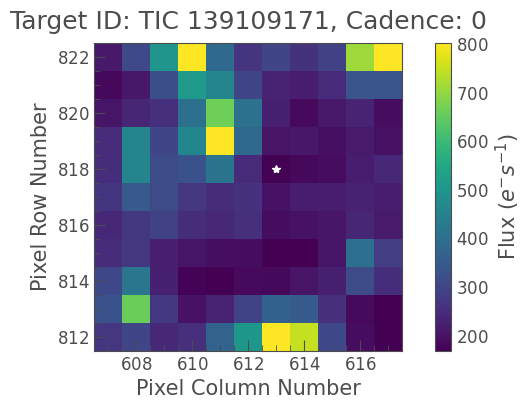

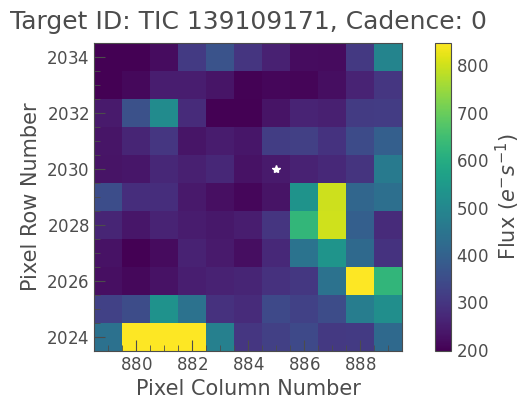

In [89]:
for i in range(len(search_result)):
    plot_traget(search_result[i])

In [94]:
tpf_crowded = search_result[5]

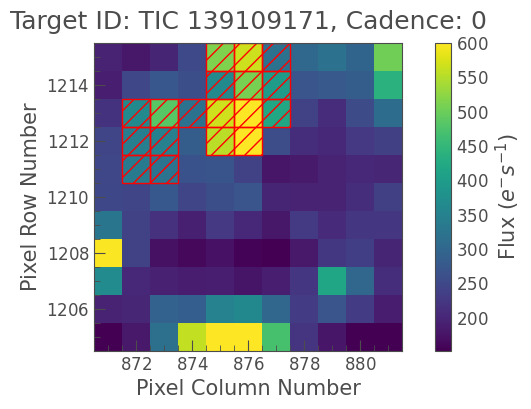

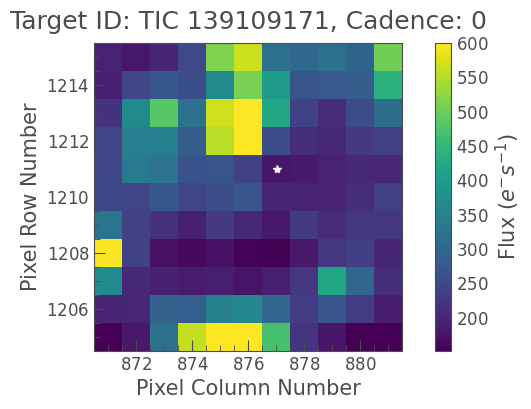

In [95]:
custom_mask = tpf_crowded.create_threshold_mask(threshold=1, reference_pixel=(7,5))
tpf_crowded.plot(aperture_mask=custom_mask);
plot_traget(tpf_crowded)

In [50]:
search_result[0].hdu[1].header['2CRPX4']+search_result[0].column

58.0008562898272

In [41]:
from lightkurve.search import _search_products

In [42]:
_search_products('TIC 184011293', radius=3*21/3600, filetype='FFI', mission='TESS')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,TESScut,1426,TIC 184011293,0.0
1,TESS Sector 14,2019,TESScut,1426,TIC 184011293,0.0
2,TESS Sector 41,2021,TESScut,475,TIC 184011293,0.0
3,TESS Sector 40,2021,TESScut,475,TIC 184011293,0.0
4,TESS Sector 54,2022,TESScut,475,TIC 184011293,0.0
5,TESS Sector 55,2022,TESScut,475,TIC 184011293,0.0
6,TESS Sector 81,2024,TESScut,158,TIC 184011293,0.0
7,TESS Sector 74,2024,TESScut,158,TIC 184011293,0.0


In [15]:
def check_spoc_availability(tic_ids):
    """
    Check which TIC IDs have SPOC light curves available.
    
    Parameters:
    -----------
    tic_ids : list or array-like
        List of TIC IDs to check
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing TIC IDs and their SPOC availability status
    """
    results = []
    
    for tic_id in tic_ids:
        try:
            search_result = lk.search_lightcurve(f'TIC {tic_id}', author='SPOC')
            
            has_spoc = len(search_result) > 0
            
            results.append({
                'tic_id': tic_id,
                'has_spoc': has_spoc,
                'num_curves': len(search_result) if has_spoc else 0
            })
            
            time.sleep(1)
            
        except Exception as e:
            print(f"Error processing TIC {tic_id}: {str(e)}")
            results.append({
                'tic_id': tic_id,
                'has_spoc': False,
                'num_curves': 0,
                'error': str(e)
            })
    
    return pd.DataFrame(results)

data = pd.read_csv('kic_to_tic_results.csv')  

results_df = check_spoc_availability(data['TIC_ID'].tolist())

In [16]:
results_df

,tic_id,has_spoc,num_curves
0,138960309,False,0
1,139109608,False,0
2,139153918,False,0
3,138970733,False,0
4,139109420,False,0
5,184010775,False,0
6,139154440,False,0
7,184163632,False,0
8,184164110,False,0
9,138970327,False,0


In [368]:
tess_ids = []
kepler_ids = []
for i in tess_data_info:
    tess_ids.append(str(i['TIC']))
    kepler_ids.append(str(i['KIC']))

In [369]:
tess_ids, kepler_ids

(['139109448',
  '139153729',
  '139154241',
  '139109202',
  '139154490',
  '139109448',
  '139109202',
  '139109202'],
 ['5024122',
  '5024008',
  '5112268',
  '4937169',
  '5112871',
  '5024182',
  '4937149',
  '4937119'])